# Selecting Isolated AGB Stars from the PHAT catalog

I am using magnitude and color cuts come from: http://aspbooks.org/publications/497/413.pdf. These were selected from the full photometric PHAT catalog using the TAP ViZier service which allowed me to run an SQL query on the very large data table: http://tapvizier.u-strasbg.fr/adql/?%20J/ApJS/215/9/table5.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KDTree 

import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import pickle

### Lets inspect the data

In [2]:
agbTable = pd.read_csv('phatAGB.csv')
agbTable[:5]

,RAJ2000,DEJ2000,F275W,s_F275W,q_F275W,F336W,s_F336W,q_F336W,F475W,s_F475W,...,F814W,s_F814W,q_F814W,F110W,s_F110W,q_F110W,F160W,s_F160W,q_F160W,F110W.1
0,11.046066,41.179477,NaN,-0.6,F,NaN,-1.6,F,25.749,25.3,...,20.454,340.8,T,18.409,826.9,T,17.330,1013.8,T,1.079
1,11.046332,41.159781,28.094,0.3,F,26.025,4.2,F,24.930,49.1,...,20.769,296.0,T,18.826,683.3,T,17.745,842.0,T,1.081
2,11.047061,41.151926,28.895,0.2,F,NaN,-0.3,F,26.359,16.7,...,20.900,276.7,T,18.971,630.6,T,17.900,772.3,T,1.071
3,11.047912,41.159434,NaN,-1.2,F,29.612,0.2,F,23.856,89.7,...,19.909,443.7,T,18.364,851.5,T,17.349,1013.0,T,1.015
4,11.048237,41.162088,27.240,0.7,F,30.487,0.1,F,23.764,94.7,...,20.030,422.9,T,18.723,708.2,T,17.778,813.2,T,0.945


### check to make sure the query worked

Should give return a tuple of False

In [3]:
agbTable['F160W'].any() > 18.2, (agbTable['F110W'] - agbTable['F160W']).any() < 0.9

(False, False)

### Visualize the Data

292580


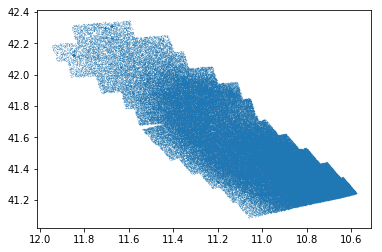

In [4]:
ra = agbTable["RAJ2000"]
dec = agbTable["DEJ2000"]

print(len(ra))
plt.scatter(ra, dec, s=0.01)
plt.gca().invert_xaxis()

### Need to select isolated objects that approximate the resolution of ZTF which I am going to approximate as $r_{ij}<2"$

In [5]:
X = np.array([ra,dec])
X.shape

(2, 292580)

Can use a KDTree to efficiently get the inter-object distances 

In [6]:
tree = KDTree(X.T, leaf_size=2)        
s = pickle.dumps(tree)                     
tree_copy = pickle.loads(s)                
dist, ind = tree_copy.query(X.T, k=2)     


### Make the seperation cut and see what it looks like

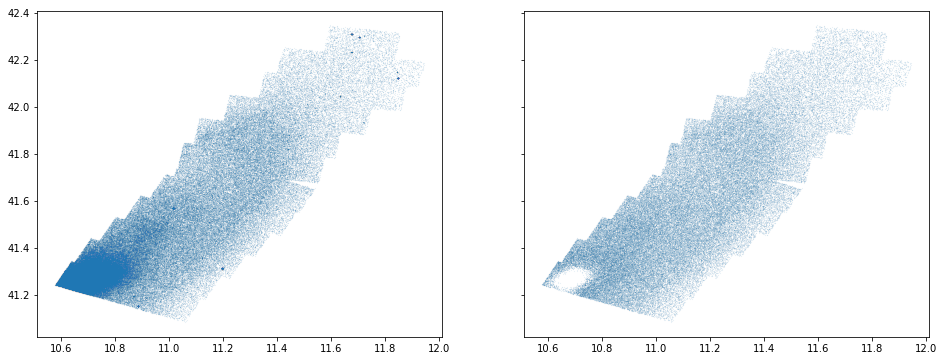

In [7]:
distCut = dist[:,1] > 2/3600 # degrees per arcsec
distCut.shape, dist.shape
#print(len(dist[distCut]))
# index = ind[distCut].flatten()

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16,6), sharey=True)
ax1.scatter(ra, dec, s=0.001)
ax2.scatter(ra[distCut], dec[distCut], s=0.001)

plt.show()

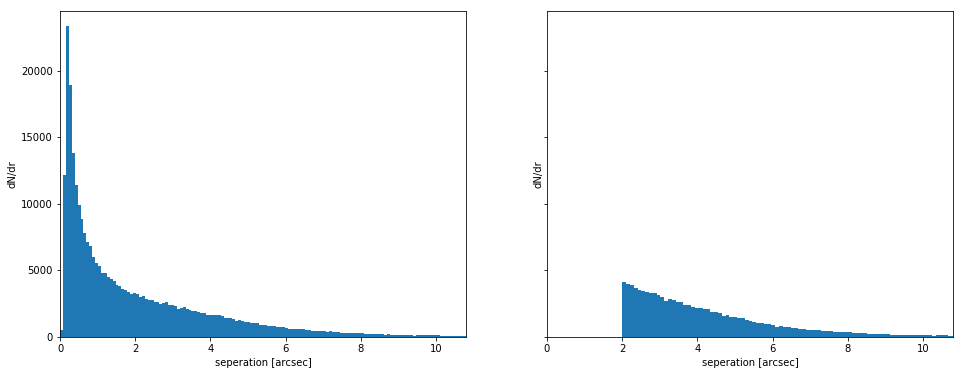

In [8]:
fig,(ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16,6), sharey=True)
ax1.hist(dist[:,1]*3600, bins='auto')
ax1.set_xlim(0,0.003*3600)
ax1.set_xlabel("seperation [arcsec]")
ax1.set_ylabel("dN/dr")

ax2.hist(dist[:,1][distCut]*3600, bins='auto')
ax2.set_xlim(0,0.003*3600)
ax2.set_xlabel("seperation [arcsec]")
ax2.set_ylabel("dN/dr")

plt.show()

### Create an astropy table from this sampe and write it out to an ipac table

In [9]:
agbSample = Table.from_pandas(agbTable[dist[:,1] > 2/3600]) # cut for distance
agbSampleCoords = Table([agbSample['RAJ2000'], agbSample['DEJ2000']])
agbSampleCoords['RAJ2000'].name = 'ra'
agbSampleCoords['DEJ2000'].name = 'dec'
# agbSampleCoords = agbSample[agbSample['ra'],agbSample['dec']]
agbSampleCoords.write('agb_coords.dat', format='ascii.ipac', overwrite=True)
len(agbSampleCoords)

108313